# Лабораторна робота №1: Вступ до Штучного Інтелекту

## Мета роботи
Розробити алгоритм генерації графу у вигляді дороги з квадратною сіткою та реалізувати його візуалізацію.

## Завдання
1. Створити алгоритм генерації графу-дороги у вигляді квадратної сітки
2. Реалізувати функцію видалення певної кількості ребер
3. Розробити візуальне представлення графу

## 1. Встановлення та імпорт необхідних бібліотек

In [8]:
!pip3 install matplotlib networkx

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [9]:
import random
import matplotlib.pyplot as plt
import networkx as nx
from typing import List, Tuple, Set

## 2. Алгоритм генерації графу-дороги

In [10]:
class RoadGraph:
    def __init__(self, size: int, edges_to_remove: int = 0):
        self.size = size
        self.edges_to_remove = edges_to_remove
        self.graph = {}
        self.removed_edges = set()
        self.generate_grid_graph()
        
    def generate_grid_graph(self):
        for i in range(self.size):
            for j in range(self.size):
                node = (i, j)
                self.graph[node] = []
                
                if j < self.size - 1:
                    neighbor = (i, j + 1)
                    self.graph[node].append(neighbor)
                
                if i < self.size - 1:
                    neighbor = (i + 1, j)
                    self.graph[node].append(neighbor)
                
                if j > 0:
                    neighbor = (i, j - 1)
                    if neighbor not in self.graph[node]:
                        self.graph[node].append(neighbor)
                
                if i > 0:
                    neighbor = (i - 1, j)
                    if neighbor not in self.graph[node]:
                        self.graph[node].append(neighbor)
        
        if self.edges_to_remove > 0:
            self.remove_random_edges_safely()
    
    def get_all_edges(self) -> List[Tuple[Tuple[int, int], Tuple[int, int]]]:
        edges = []
        visited = set()
        
        for node in self.graph:
            for neighbor in self.graph[node]:
                edge = tuple(sorted([node, neighbor]))
                if edge not in visited:
                    edges.append((node, neighbor))
                    visited.add(edge)
        
        return edges
    
    def remove_random_edges_safely(self):
        all_edges = self.get_all_edges()
        
        min_edges_for_connectivity = self.size * self.size - 1
        max_removable = len(all_edges) - min_edges_for_connectivity
        
        if max_removable <= 0:
            print(f"граф {self.size}x{self.size} потребує всі ребра для зв'язності")
            return
            
        edges_to_remove = min(self.edges_to_remove, max_removable)
        
        print(f"всього ребер: {len(all_edges)}")
        print(f"мін. для зв'язності: {min_edges_for_connectivity}")
        print(f"макс. можна видалити: {max_removable}")
        print(f"буде видалено: {edges_to_remove}")
        
        edges_to_remove_list = random.sample(all_edges, edges_to_remove)
        
        for edge in edges_to_remove_list:
            node1, node2 = edge
            
            if node2 in self.graph[node1]:
                self.graph[node1].remove(node2)
            if node1 in self.graph[node2]:
                self.graph[node2].remove(node1)
                
            self.removed_edges.add(tuple(sorted([node1, node2])))
            
            if not self.is_connected():
                print(f"увага: видалення ребра {edge} порушило зв'язність, повертаю назад")
                if node1 not in self.graph[node2]:
                    self.graph[node1].append(node2)
                if node2 not in self.graph[node1]:
                    self.graph[node2].append(node1)
                self.removed_edges.remove(tuple(sorted([node1, node2])))
    
    def is_connected(self) -> bool:
        if not self.graph:
            return True
        
        start_node = list(self.graph.keys())[0]
        visited = set()
        queue = [start_node]
        
        while queue:
            node = queue.pop(0)
            if node not in visited:
                visited.add(node)
                for neighbor in self.graph[node]:
                    if neighbor not in visited:
                        queue.append(neighbor)
        
        return len(visited) == len(self.graph)

## 3. Візуалізація графу за допомогою matplotlib

In [11]:
def visualize_road_graph(road_graph: RoadGraph, title: str = "Граф-дорога"):
    plt.figure(figsize=(10, 10))
    
    G = nx.Graph()
    
    for node in road_graph.graph:
        G.add_node(node)
    
    for node in road_graph.graph:
        for neighbor in road_graph.graph[node]:
            G.add_edge(node, neighbor)
    
    pos = {(i, j): (j, road_graph.size - 1 - i) for i in range(road_graph.size) for j in range(road_graph.size)}
    
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
    
    existing_edges = [(u, v) for u, v in G.edges() if tuple(sorted([u, v])) not in road_graph.removed_edges]
    nx.draw_networkx_edges(G, pos, edgelist=existing_edges, edge_color='black', width=2)
    
    labels = {node: f"{node[0]},{node[1]}" for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    plt.title(title)
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 4. ASCII візуалізація графу

In [12]:
def ascii_visualization(road_graph: RoadGraph):
    size = road_graph.size
    ascii_grid = [[' ' for _ in range(size * 4 - 1)] for _ in range(size * 2 - 1)]
    
    for i in range(size):
        for j in range(size):
            ascii_grid[i * 2][j * 4] = 'o'
    
    for i in range(size):
        for j in range(size - 1):
            node1 = (i, j)
            node2 = (i, j + 1)
            if node2 in road_graph.graph[node1]:
                for k in range(1, 4):
                    ascii_grid[i * 2][j * 4 + k] = '-'
    
    for i in range(size - 1):
        for j in range(size):
            node1 = (i, j)
            node2 = (i + 1, j)
            if node2 in road_graph.graph[node1]:
                ascii_grid[i * 2 + 1][j * 4] = '|'
    
    print("\nASCII візуалізація графу-дороги:")
    print("=" * (size * 4 - 1))
    for row in ascii_grid:
        print(''.join(row))
    print("=" * (size * 4 - 1))

## 5. Тестування алгоритму

=== ТЕСТ: Видалення максимальної кількості ребер зі збереженням зв'язності ===
всього ребер: 40
мін. для зв'язності: 24
макс. можна видалити: 16
буде видалено: 16
увага: видалення ребра ((1, 4), (2, 4)) порушило зв'язність, повертаю назад
увага: видалення ребра ((2, 2), (2, 3)) порушило зв'язність, повертаю назад
увага: видалення ребра ((3, 0), (4, 0)) порушило зв'язність, повертаю назад
увага: видалення ребра ((2, 0), (3, 0)) порушило зв'язність, повертаю назад
увага: видалення ребра ((2, 2), (3, 2)) порушило зв'язність, повертаю назад
увага: видалення ребра ((1, 0), (1, 1)) порушило зв'язність, повертаю назад
увага: видалення ребра ((3, 2), (3, 3)) порушило зв'язність, повертаю назад
увага: видалення ребра ((1, 2), (1, 3)) порушило зв'язність, повертаю назад
увага: видалення ребра ((1, 2), (2, 2)) порушило зв'язність, повертаю назад
увага: видалення ребра ((1, 1), (2, 1)) порушило зв'язність, повертаю назад
увага: видалення ребра ((4, 3), (4, 4)) порушило зв'язність, повертаю назад



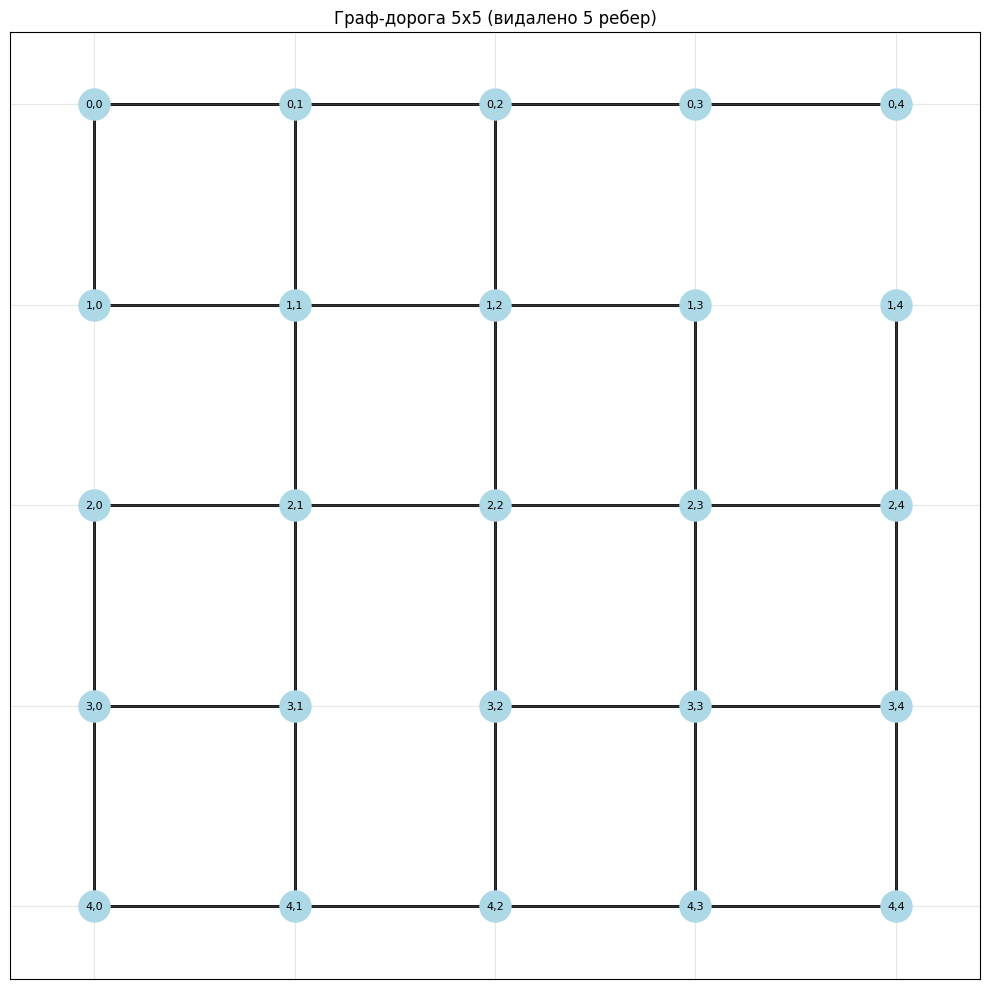

In [13]:
GRAPH_SIZE = 5
EDGES_TO_REMOVE = 16

print("=== ТЕСТ: Видалення максимальної кількості ребер зі збереженням зв'язності ===")
road_graph = RoadGraph(size=GRAPH_SIZE, edges_to_remove=EDGES_TO_REMOVE)

print(f"\nРозмір графу: {GRAPH_SIZE}x{GRAPH_SIZE} ({GRAPH_SIZE**2} вершин)")
print(f"Запитано видалити: {EDGES_TO_REMOVE} ребер")
print(f"Фактично видалено: {len(road_graph.removed_edges)} ребер")
print(f"Граф зв'язний: {'ТАК ✓' if road_graph.is_connected() else 'НІ ✗'}")

ascii_visualization(road_graph)

visualize_road_graph(road_graph, f"Граф-дорога {GRAPH_SIZE}x{GRAPH_SIZE} (видалено {len(road_graph.removed_edges)} ребер)")

## 6. Приклади з різними параметрами

Приклад 1: Повний граф 5x5

ASCII візуалізація графу-дороги:
o---o---o---o---o  
|   |   |   |   |  
o---o---o---o---o  
|   |   |   |   |  
o---o---o---o---o  
|   |   |   |   |  
o---o---o---o---o  
|   |   |   |   |  
o---o---o---o---o  


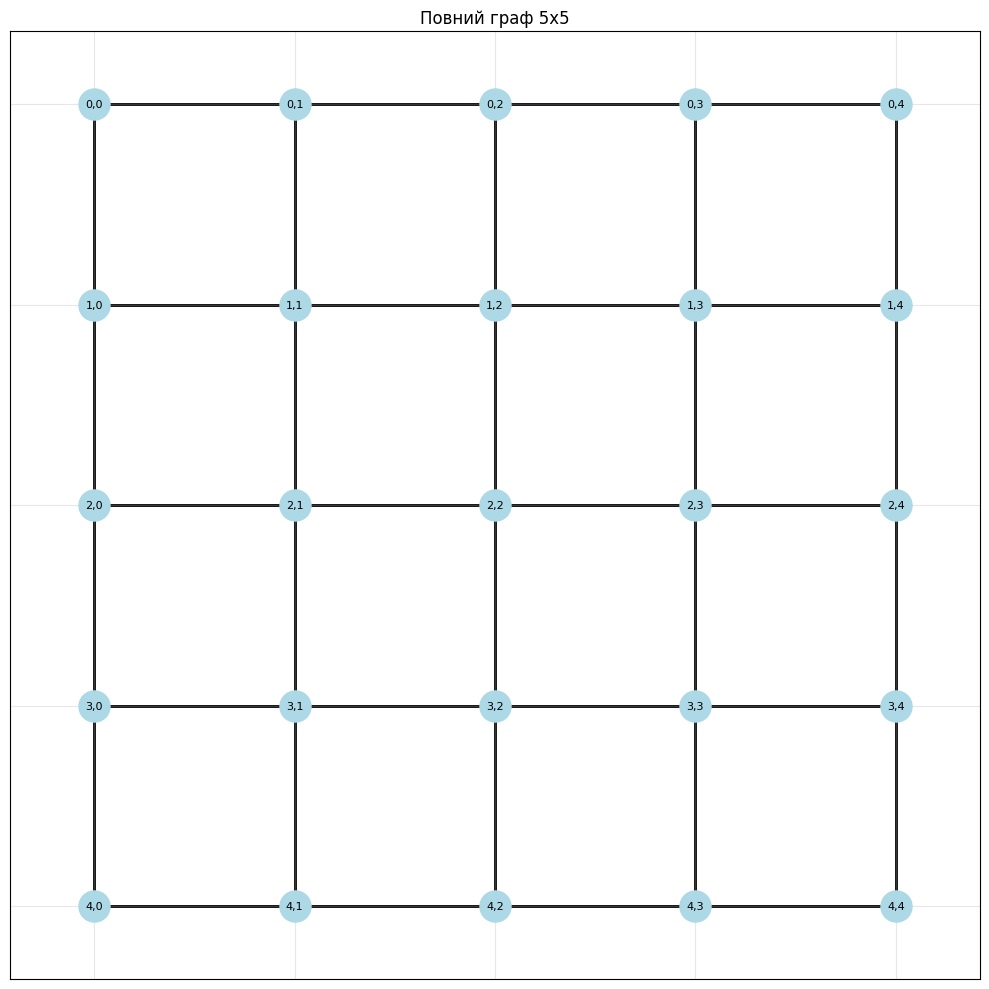

In [14]:
print("Приклад 1: Повний граф 5x5")
road_graph1 = RoadGraph(size=5, edges_to_remove=0)
ascii_visualization(road_graph1)
visualize_road_graph(road_graph1, "Повний граф 5x5")

=== ТЕСТ: Перевищення максимуму (спроба видалити 20 ребер) ===
всього ребер: 40
мін. для зв'язності: 24
макс. можна видалити: 16
буде видалено: 16
увага: видалення ребра ((0, 3), (0, 4)) порушило зв'язність, повертаю назад
увага: видалення ребра ((0, 2), (0, 3)) порушило зв'язність, повертаю назад
Граф зв'язний: ТАК ✓
Фактично видалено: 14 ребер

ASCII візуалізація графу-дороги:
o---o---o---o---o  
        |          
o---o---o---o   o  
    |   |   |   |  
o   o   o---o---o  
|       |   |      
o---o---o---o---o  
    |       |   |  
o---o   o---o   o  


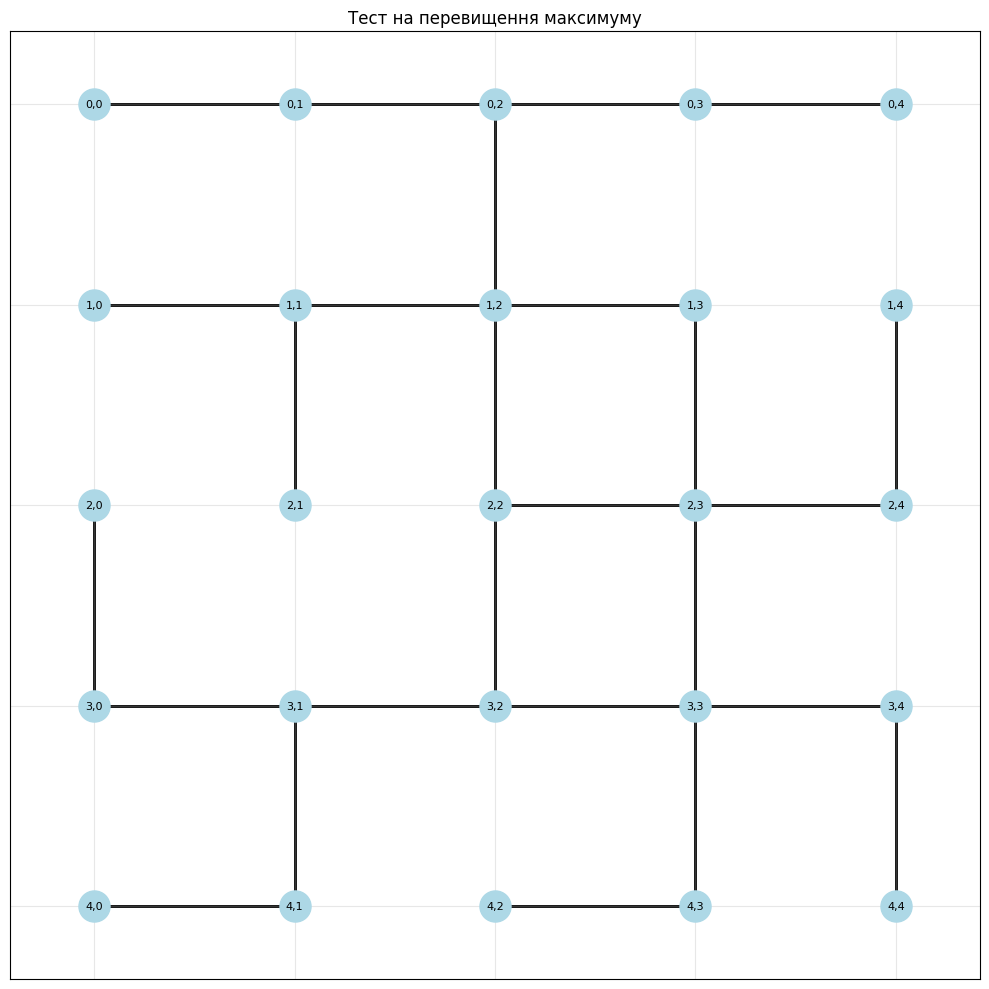

In [15]:
print("=== ТЕСТ: Перевищення максимуму (спроба видалити 20 ребер) ===")
road_graph2 = RoadGraph(size=5, edges_to_remove=20)
print(f"Граф зв'язний: {'ТАК ✓' if road_graph2.is_connected() else 'НІ ✗'}")
print(f"Фактично видалено: {len(road_graph2.removed_edges)} ребер")
ascii_visualization(road_graph2)
visualize_road_graph(road_graph2, "Тест на перевищення максимуму")

Приклад 3: Граф розміром 25 перехресть (5x5)
Загальна кількість перехресть: 25

ASCII візуалізація графу-дороги:
o---o---o---o---o  
|   |   |   |   |  
o---o---o---o---o  
|   |   |   |   |  
o---o---o---o---o  
|   |   |   |   |  
o---o---o---o---o  
|   |   |   |   |  
o---o---o---o---o  


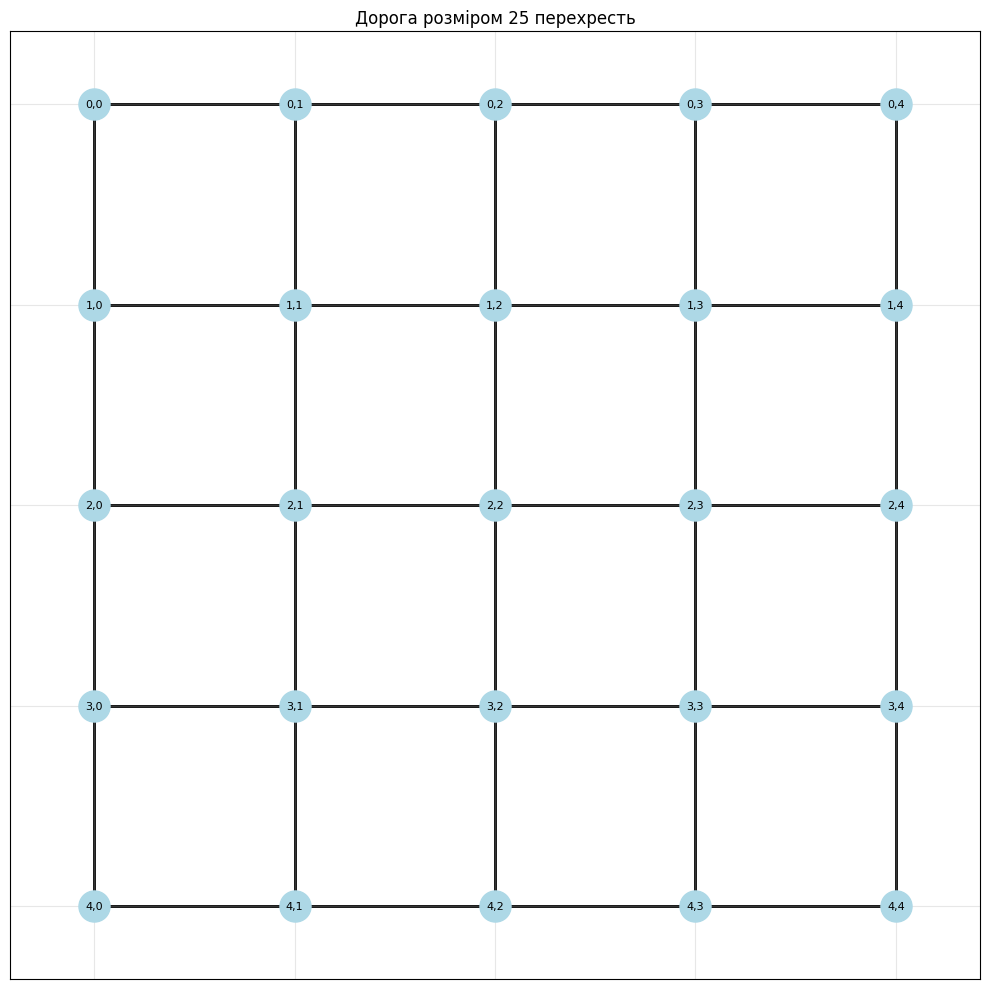

In [16]:
print("Приклад 3: Граф розміром 25 перехресть (5x5)")
default_graph = RoadGraph(size=5, edges_to_remove=0)
total_intersections = 5 * 5
print(f"Загальна кількість перехресть: {total_intersections}")
ascii_visualization(default_graph)
visualize_road_graph(default_graph, "Дорога розміром 25 перехресть")

## 7. Додаткова візуалізація з використанням іншої бібліотеки

In [17]:
def enhanced_ascii_visualization(road_graph: RoadGraph):
    size = road_graph.size
    
    print(f"\nASCII візуалізація {size}x{size}:")
    
    for i in range(size):
        row = ""
        for j in range(size):
            row += f"({i},{j})"
            if j < size - 1:
                node1 = (i, j)
                node2 = (i, j + 1)
                if node2 in road_graph.graph[node1]:
                    row += "---"
                else:
                    row += "   "
        print(row)
        
        if i < size - 1:
            row = ""
            for j in range(size):
                node1 = (i, j)
                node2 = (i + 1, j)
                if node2 in road_graph.graph[node1]:
                    row += "  |  "
                else:
                    row += "     "
                if j < size - 1:
                    row += "   "
            print(row)

print("=== ДОДАТКОВИЙ ТЕСТ: Різні розміри графу ===")

test_configs = [
    (3, 3, "максимум для 3x3"),
    (4, 7, "максимум для 4x4"), 
    (6, 15, "частково для 6x6")
]

for size, edges_to_remove, description in test_configs:
    print(f"\n--- {description} ---")
    test_graph = RoadGraph(size=size, edges_to_remove=edges_to_remove)
    print(f"Зв'язний: {'ТАК ✓' if test_graph.is_connected() else 'НІ ✗'}")
    print(f"Видалено: {len(test_graph.removed_edges)} з {edges_to_remove} запитаних")
    
    if size <= 4:
        enhanced_ascii_visualization(test_graph)

=== ДОДАТКОВИЙ ТЕСТ: Різні розміри графу ===

--- максимум для 3x3 ---
всього ребер: 12
мін. для зв'язності: 8
макс. можна видалити: 4
буде видалено: 3
Зв'язний: ТАК ✓
Видалено: 3 з 3 запитаних

ASCII візуалізація 3x3:
(0,0)---(0,1)---(0,2)
          |       |  
(1,0)   (1,1)   (1,2)
  |       |       |  
(2,0)---(2,1)---(2,2)

--- максимум для 4x4 ---
всього ребер: 24
мін. для зв'язності: 15
макс. можна видалити: 9
буде видалено: 7
увага: видалення ребра ((0, 2), (0, 3)) порушило зв'язність, повертаю назад
Зв'язний: ТАК ✓
Видалено: 6 з 7 запитаних

ASCII візуалізація 4x4:
(0,0)---(0,1)---(0,2)---(0,3)
                  |          
(1,0)---(1,1)   (1,2)---(1,3)
  |       |       |       |  
(2,0)---(2,1)   (2,2)   (2,3)
  |       |       |       |  
(3,0)---(3,1)---(3,2)---(3,3)

--- частково для 6x6 ---
всього ребер: 60
мін. для зв'язності: 35
макс. можна видалити: 25
буде видалено: 15
увага: видалення ребра ((0, 0), (1, 0)) порушило зв'язність, повертаю назад
Зв'язний: ТАК ✓
Видалено

## Висновки

У цій лабораторній роботі було реалізовано:

1. **Алгоритм генерації графу-дороги** у вигляді квадратної сітки з конфігурованими параметрами
2. **Функцію видалення ребер** з можливістю контролю кількості видалених з'єднань
3. **Візуалізацію графу** двома способами:
   - ASCII представлення для текстового виводу
   - Графічне представлення за допомогою matplotlib та networkx
4. **Перевірку зв'язності графу** після видалення ребер

Алгоритм дозволяє створювати різні конфігурації дорожніх мереж з можливістю моделювання перекритих доріг.